In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import logging
logging.basicConfig(filename='error.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import gensim
import pickle
from gensim import corpora
from gensim.utils import smart_open, simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from sklearn import cross_validation
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm, tqdm_notebook, tnrange
from sklearn.externals import joblib
from scipy.sparse import csr_matrix
from scipy import io
import numpy as np
from math import sqrt

In [22]:
train = pd.read_csv("../data/processed/comedy_comparisons.train")
test = pd.read_csv("../data/processed/comedy_comparisons.test")

In [18]:
def feature_sum_score(dataset_df, normalized=True):
    """
    This functions creates a score for each video which is the sum(better)-sum(worse)
    :param dataset_df: The dataset panda dataframe
    :return: Normalized series with the final score [-1..1] and the video_id's as index
    """
    better1 = dataset_df[dataset_df.funnier == 'left'].video_id1.sort_index().value_counts()
    better2 = dataset_df[dataset_df.funnier == 'right'].video_id2.sort_index().value_counts()
    better = better1.add(better2, fill_value=0).sort_index()
    worse1 = dataset_df[dataset_df.funnier == 'right'].video_id1.sort_index().value_counts()
    worse2 = dataset_df[dataset_df.funnier == 'left'].video_id2.sort_index().value_counts()
    worse = worse1.add(worse2, fill_value=0).sort_index()
    score = better.subtract(worse, fill_value=0).sort_index()
    if normalized:
        max_score = score.abs().max()
        assert max_score != 0
        score = score / max_score

    return score

In [19]:
#score_train = feature_sum_score(train)
#score_test = feature_sum_score(test)

score_train_not_norm = feature_sum_score(train, normalized=False)
score_test_not_norm = feature_sum_score(test, normalized=False)

In [11]:
def get_corpus(df, dictionary, pbar=None):
    corpus = []
    df1 = {}
    for i, row in enumerate(df.itertuples()):
        curbow = dictionary.doc2bow(tokenize(row.textDisplay))
        corpus.append(curbow)
        if not pbar is None:
            pbar.update(1)
    #corpus['score'] = get_label(df, score, dictionary)
    return corpus

# From the df, get all comments by video_id
def get_corpus_by_video_id(df, dictionary, pbar=None):
    corpus = []
    df1 = df.groupby('videoId')['textDisplay'].apply(lambda x: "{%s}" % ' '.join(x))
    # Series is returned
    for ind, val in df1.iteritems():
        curbow = dictionary.doc2bow(tokenize(val))
        corpus.append(curbow)
        if not pbar is None:
            pbar.update(1)
    #corpus['score'] = get_label(df, score, dictionary)
    return corpus


In [14]:
def get_label(df, score, dictionary):
    label = []
    for i, row in enumerate(df.itertuples()):
        if row.videoId in score:
            label.append(score[row.videoId])
        else:
            label.append(0)
    return label

def get_label_by_video_id(df, score, dictionary):
    label = []
    df1 = df.groupby('videoId')['textDisplay'].apply(lambda x: "{%s}" % ' '.join(x))
    for ind, val in df1.iteritems():
        if ind in score.index:
            label.append(score[ind])
        else:
            label.append(0)
    return label

In [22]:
data = pd.read_csv("../data/processed/train_dataset_with_lang_feature.csv")
data_en = data[data.language == 'en']
len(data_en)
data_en.head(10)

/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (3,4,5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,videoId,textDisplay,isReplyTo,canReply,totalReplyCount,kind,etag,id,authorChannelId,authorDisplayName,likeCount,publishedAt,updatedAt,viewerRating,language
0,0,sNabaB-eb3Y,They should made this as a double prank.. when...,NaN,NaN,0,youtube#commentThread,"""I_8xdZu766_FSaexEaDXTIfEWc0/_aVRgxW14TFYS3sZy...",z23vvfnwmozww3ukvacdp433u2l5tjjzue32obodyxlw03...,{'value': 'UCDjudKsbl2T2KeanD-nrKXw'},Grise Blacolar,0,2013-05-15T16:41:33.000Z,2013-05-15T16:41:33.000Z,none,en
1,1,sNabaB-eb3Y,People are friendlier here than in other state...,NaN,NaN,0,youtube#commentThread,"""I_8xdZu766_FSaexEaDXTIfEWc0/AOKhrA3U9J8iGUkun...",z22uxrrpaxiuyj5ri04t1aokg2ftoiu5vmacden0g5hzbk...,{'value': 'UCLBkXylBjiV0mN1dNhjIRbg'},alphacino,0,2012-11-04T16:32:45.000Z,2012-11-04T16:32:45.000Z,none,en
2,2,sNabaB-eb3Y,"I do live in Texas, how did you guess?!?!?!?!﻿",NaN,NaN,0,youtube#commentThread,"""I_8xdZu766_FSaexEaDXTIfEWc0/gxMEOZY-YvfKneJSI...",z222innj3rmgxhlzp04t1aokg5c1sf24ibuxgughzte0rk...,{'value': 'UCXc-CFxsN7iXSL6X4-dDfYQ'},Lumilan,0,2012-11-04T16:21:29.000Z,2012-11-04T16:21:29.000Z,none,en
3,3,sNabaB-eb3Y,you mist live in texas. or maybe new york. you...,NaN,NaN,0,youtube#commentThread,"""I_8xdZu766_FSaexEaDXTIfEWc0/K88xlkocl8TtWTMMt...",z22uxrrpaxiuyj5ri04t1aokgvgnbgrn4ewpkvjulgacrk...,{'value': 'UCLBkXylBjiV0mN1dNhjIRbg'},alphacino,0,2012-11-04T13:43:51.000Z,2012-11-04T13:43:51.000Z,none,en
4,4,sNabaB-eb3Y,They should have just opened the door with the...,NaN,NaN,0,youtube#commentThread,"""I_8xdZu766_FSaexEaDXTIfEWc0/3NozddevGyZcalCaO...",z23tdtdihp3sz3emtacdp43afln2va1zwj4c2wnmljxw03...,{'value': 'UCY8-Q3GTP-a4yZ99GpG4Qww'},PandaMagicFTW,0,2012-10-02T21:35:52.000Z,2012-10-02T21:35:52.000Z,none,en
5,5,sNabaB-eb3Y,i love the music on JFL﻿,NaN,NaN,0,youtube#commentThread,"""I_8xdZu766_FSaexEaDXTIfEWc0/IRtPfKJcI4PawitZJ...",z23nebibyze2cb3pn04t1aokgkzznfqtt5wqaf5ebm3nbk...,{'value': 'UCXX6ufMotDsRRMj_1BiBk_w'},kimmyw010,0,2012-08-25T04:50:19.000Z,2012-08-25T04:50:19.000Z,none,en
6,6,sNabaB-eb3Y,It has 6 human power﻿,NaN,NaN,0,youtube#commentThread,"""I_8xdZu766_FSaexEaDXTIfEWc0/mi6gcIdUHEWkn0TKZ...",z23pzpz5vvmrjji0facdp4350cxxomrhh0vdeykuf4tw03...,{'value': 'UCbigvKFMTwsUX1FBhvYY6Tg'},SlickR12345,0,2012-06-26T12:59:15.000Z,2012-06-26T12:59:15.000Z,none,en
7,7,sNabaB-eb3Y,JustForLaughs is like an institution. Loads of...,NaN,NaN,0,youtube#commentThread,"""I_8xdZu766_FSaexEaDXTIfEWc0/d1OXVB16zaiNit0kA...",z22yjr1grzrdeviap04t1aokgb1oyubgsfvzaxkrilrgbk...,{'value': 'UCS3Ri5tvGweVXwzUDGd-8RQ'},TheCulturalBomb,0,2012-06-20T02:17:52.000Z,2012-06-20T02:17:52.000Z,none,en
8,8,sNabaB-eb3Y,thumbs up if you saw the lauriel and hardy pos...,NaN,NaN,0,youtube#commentThread,"""I_8xdZu766_FSaexEaDXTIfEWc0/vqHiKYG7jh576wOsi...",z224tfyjmkrjhffqm04t1aokgr10lkpvdkr5hv23chkebk...,{'value': 'UCih6jccG8q_rVCkqRcm3avQ'},MiguelBug,0,2012-05-16T13:22:37.000Z,2012-05-16T13:22:37.000Z,none,en
9,9,sNabaB-eb3Y,look at the shape of the key @1:11....lol lol ...,NaN,NaN,0,youtube#commentThread,"""I_8xdZu766_FSaexEaDXTIfEWc0/xzPbrBd0AJEttdE_c...",z23qjnzo2xz0ujr4a04t1aokggyigqzp4h4hecowxdz2rk...,{'value': 'UCCWyqVEPJS3v53ggTYfRGNA'},varkyjas10,0,2012-03-27T10:05:55.000Z,2012-03-27T10:05:55.000Z,none,en


In [23]:
data_test = pd.read_csv("../data/processed/test_dataset_with_lang_feature.csv")
data_test_en = data_test[data_test.language == 'en']
len(data_test_en)

/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (3,4,5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2312215

In [9]:
seed = 85
dat = data.sample(10000, random_state=seed)
dat_test = data_test.sample(1000, random_state=seed)
all_data = pd.concat([dat, dat_test])
len(all_data)

11000

In [10]:
def tokenize(text):
    ret = []
    i = 0
    token = ""
    try:
        for token in simple_preprocess(text):
            if token not in STOPWORDS:
                ret.append(token)
            i = i + 1
        #ret = [token for token in simple_preprocess(text) if token not in STOPWORDS]
    except Exception as e:
        logging.error("Error in line: ", i, " cur token:", token, " error", e)
        pass
        # print("ERROR in line: ", i)
        # print("Cur token", token)
        # print("ERROR: ", e)
    return ret
        
        

def iter_comments(commentsIterable):
    for entry in commentsIterable:
        comment = tokenize(entry[2])
        yield entry[1], comment

In [15]:
# Create a dicrionary out of the comments and save it
commentsList = data_en[['videoId', 'textDisplay']].dropna().itertuples()
stream = iter_comments(commentsList)
doc_stream = (tokens for _, tokens in stream)
id2word = gensim.corpora.Dictionary(doc_stream)
id2word.save('../data/processed/youtube_comments_en.dict')

In [16]:
len(id2word)

685091

In [21]:
id2word = gensim.corpora.Dictionary.load('../data/processed/youtube_comments_en.dict')

In [10]:
def tokenize(text):
    ret = []
    i = 0
    token = ""
    try:
        for token in simple_preprocess(text):
            if token not in STOPWORDS:
                ret.append(token)
            i = i + 1
        #ret = [token for token in simple_preprocess(text) if token not in STOPWORDS]
    except Exception as e:
        pass
        # print("ERROR in line: ", i)
        # print("Cur token", token)
        # print("ERROR: ", e)
    return ret
        

In [27]:
all_data = pd.concat([data_en, data_test_en])

In [24]:
video_id_size = len(pd.unique(all_data.videoId))
video_id_size

10170

In [30]:
pbar = tqdm_notebook(video_id_size, desc="Creating corpus")
corpus = get_corpus_by_video_id(all_data, id2word, pbar)
for i, row in corpus.iteritems():
    print("Index: ", i, "Value:", row)
print("Print ended!")
corpus

videoId
--epPVcv4W0    {Filmed in Scotland...﻿ the actor looks like t...
--u9JclfPz0    {Not 1.. Not 2.. Not 15 TV's.. We actua.. We h...
-0_iw2b9fXY    {ITs funnier when he says his son luke says th...
-0lrQdFmL9U    {It's almost like Jarvis.\n\nBut the fact that...
-0xKFnorzKY    {you really have a deadpan style of comedy tha...
-1IzPnh43FQ                {Anyone know where this was filmed?﻿}
-1Ud2FdJ8NQ    {are you fucking seriously doing this\n1: this...
-2Tn70_1OA8                               {I creamed a little.﻿}
-3P57xi7jMA    {only employees can enter Hahaha!﻿ Feel really...
-3g_ENHcvGY    {@theSpooofguys haha thanks, my baby cousin sa...
-3lppfJv8IQ    {Good old 2008 cat videos.﻿ Made it out the do...
-4hsU6uYaoQ    {When the guy raises his hand, then puts it ba...
-52cU8PfI_c    {Sometimes you dont need a present to celebrat...
-5zGEXK42f4    {What happened to this :P﻿ +Amelia Luu Lol yea...
-6UdimnqcZ4          {Cole too drunk lol﻿ Light skin brothas'.﻿}
-6epnDtbAVc    {y

In [44]:
pbar = tqdm_notebook(range(video_id_size), desc="Creating corpus")
corpus = get_corpus_by_video_id(all_data, id2word, pbar)
scipy_corpus = gensim.matutils.corpus2csc(corpus)


In [45]:
corpora.MmCorpus.serialize('../data/processed/fullcorpus_en_per_video_id.mm', corpus)

In [16]:
corpus = corpora.MmCorpus('../data/processed/fullcorpus_en_per_video_id.mm')


In [17]:
scipy_corpus = gensim.matutils.corpus2csc(corpus)


In [24]:
#np.savez(file='../data/processed/scipy_corpus_en_per_video_id.np', data=scipy_corpus.data, 
#         indices=scipy_corpus.indices, indptr=scipy_corpus.indptr, shape=scipy_corpus.shape)
io.mmwrite('../data/processed/scipy_corpus_en_per_video_id.mtx', scipy_corpus)

In [2]:
scipy_corpus = io.mmread('../data/processed/scipy_corpus_en_per_video_id.mtx').tocsr()
# loader = np.load('../data/processed/scipy_corpus_en_per_video_id.np.npz')
# scipy_corpus = csr_matrix((  loader['data'], loader['indices'], loader['indptr']),
#                          shape = loader['shape'])

In [154]:
#label = get_label(data_en, score_train_not_norm, id2word)
label = get_label_by_video_id(data_en, score_train_not_norm, id2word)


In [155]:
len(label)

8551

In [3]:
pickle.dump(label, open('../data/processed/label_en_per_video_id.p', 'wb'))

NameError: name 'label' is not defined

In [8]:
label = pickle.load(open('../data/processed/label_en_per_video_id.p', 'rb'))

In [10]:
sz_train = len(pd.unique(data_en.videoId))
sz_test = len(pd.unique(data_test_en.videoId))
train_video_id = score_train_not_norm.index
test_video_id = score_test_not_norm.index

NameError: name 'score_train_not_norm' is not defined

In [83]:
train_indices = []
data_en.groupby('videoId').apply(lambda x: x)
# for i, row in enumerate(data_en.groupby('videoId').itertuples()):
#     if row.videoId in train_video_id:
#         train_indices += [i]
len(train_indices)

SyntaxError: invalid syntax (<ipython-input-83-74459feeca78>, line 2)

In [89]:
len(pd.unique(all_data.videoId))

10170

In [25]:
all_data = [data_en, data_test_en]

In [92]:
scipy_corpus.shape

(685091, 10170)

In [28]:
train_indices = []
test_indices = []
video_id_train = []
video_id_test = []
train_video_id = pd.unique(data_en.videoId)
test_video_id = pd.unique(data_test_en.videoId)
for i, row in enumerate(pd.unique(all_data.videoId)):
    if row in test_video_id:
        video_id_test += [row]
        test_indices += [i]
    if row in train_video_id:
        video_id_train += [row]
        train_indices += [i]
(len(train_indices), len(test_indices))

(8551, 2711)

In [30]:
pickle.dump(video_id_train, open('../data/processed/video_id_train.p','wb'))
pickle.dump(video_id_test, open('../data/processed/video_id_test.p', 'wb'))

In [2]:
video_id_train = pickle.load(open('../data/processed/video_id_train.p', 'rb'))
video_id_test = pickle.load(open('../data/processed/video_id_test.p', 'rb'))

In [ ]:
(sz_train, sz_test)

In [11]:
training_size = len(train_indices)
scipy_train = scipy_corpus[:, train_indices]

In [12]:
io.mmwrite('../data/processed/scipy_corpus_train_en_per_video_id.mtx', scipy_train)

In [3]:
scipy_train = io.mmread('../data/processed/scipy_corpus_train_en_per_video_id.mtx').tocsr()

In [5]:
# Create linear regression object
regr = linear_model.LinearRegression(n_jobs=-1)

# Train the model using the training sets
regr.fit(scipy_train.transpose(), label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [6]:
joblib.dump(regr, '../models/linear_regression_en_not_norm_by_video_id.pkl')

['../models/linear_regression_en_not_norm_by_video_id.pkl',
 '../models/linear_regression_en_not_norm_by_video_id.pkl_01.npy']

In [14]:
regr = joblib.load('../models/linear_regression_en_not_norm_by_video_id.pkl')

In [22]:
scipy_test = scipy_corpus[:, test_indices]
label_test = get_label_by_video_id(data_test_en, score_train_not_norm, id2word)

In [24]:
io.mmwrite('../data/processed/scipy_corpus_test_en_per_video_id.mtx', scipy_test)

In [5]:
scipy_test = io.mmread('../data/processed/scipy_corpus_test_en_per_video_id.mtx').tocsr()

In [27]:
pickle.dump(label_test, open('../data/processed/label_test_en_per_video_id.p', 'wb'))

In [6]:
label_test = pickle.load(open('../data/processed/label_test_en_per_video_id.p', 'rb'))

In [13]:
(scipy_train.transpose().shape, len(label))

((8551, 685091), 8551)

In [15]:
print('Variance score: %.2f' % regr.score(scipy_train.transpose(), label))

Variance score: 0.99


In [16]:
y_true = label_test
y_pred = regr.predict(scipy_test.transpose())
#(len(y_true), len(y_pred), scipy_test.shape)
r2 = r2_score(y_true, y_pred)
mean_sq_error = sqrt(mean_squared_error(y_true, y_pred))
r2, mean_sq_error

(-35031.062663139623, 24326.251541764123)

In [10]:
label = pickle.load(open('../data/processed/label_en_per_video_id.p', 'rb'))
label_test = pickle.load(open('../data/processed/label_test_en_per_video_id.p', 'rb'))

In [20]:
len(y_pred)

2711

/usr/local/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


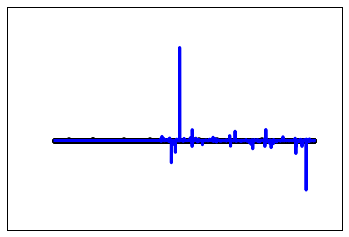

In [13]:
plt.scatter(range(len(label_test)), label_test,  color='black')
plt.plot(range(len(label_test)), regr.predict(scipy_test.transpose()), color='blue',
         linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [30]:
len(label_test)

3302579

In [31]:
len(data_test_en)

2312215

In [27]:
scipy_test.transpose()

<3302579x1109099 sparse matrix of type '<class 'numpy.float64'>'
	with 15858654 stored elements in Compressed Sparse Row format>

In [47]:
scipy_test=scipy_test.transpose()

In [41]:
video_id = np.array(data_test_en['videoId'])

In [42]:
video_id == '7VvBnz1Ngi4'

array([ True,  True,  True, ..., False, False, False], dtype=bool)

In [43]:
len(y_pred)

2312215

In [48]:
scipy_test.shape

(2312215, 685091)

In [49]:
comm_pred = regr.predict(scipy_test[video_id == '7VvBnz1Ngi4'])
sum(comm_pred)/len(comm_pred)

0.0055385235013960471

In [18]:
scipy_test.shape

(685091, 2711)

In [17]:
(len(y_pred), len(video_id_test))

(2711, 2711)

In [20]:
video_score_test = dict(zip(video_id_test, y_pred))
video_score_test

{'vRF9FbnOBjo': -2.5533862225066244,
 'Y4Fc97wVXO0': -1.4009654729932401,
 'EgE6rjNKmhI': 5.7719376214764972,
 'GT86iWiH2mI': -5.61213509842643,
 'txlVdghNlbY': -321.6991161866996,
 'CyS5VQfGFcw': 6.2893440828120184,
 'xCuQiAS7N5E': -853.0842262082266,
 '4xJ0w3kDDBo': 26532.961579694398,
 'X3RmZxZ6l4Q': 29.494966134561519,
 'wvk9baO7NkE': -54.357648171259221,
 'hcqHtfASdxc': -2209.9137303501907,
 'pvXNlI4vWLA': -9.6578440501903486,
 'uu4ZFwMyh0U': 4.3591482783893225,
 'mmSmzt8pS6Q': -77.914671056264595,
 'WVyLFrKQGXM': 563.3163414721987,
 'okYv9Tbu5OQ': -321.20846124968597,
 '3G7H5B7H3Uk': -1.6674874511034969,
 'TKGrwoqQyVY': 275.08519745655451,
 't4KvXsglvMg': -8.1405578107636316,
 'AjEiyTYg8RE': -2.7656858806632094,
 'fFfWykH05Gw': -779.33060977258799,
 'GZRDazgV3ac': 13.391090568835919,
 'AojhTY963s8': -427.64240894910699,
 'TRTcZKHkENw': -16.099988810370863,
 'TBqDY2cFbM8': 3.5677993761007785,
 'UWhVBy_o8SM': -91.820116608127535,
 '1Cr0ivdl-0o': -0.68107748389569145,
 'WcZqwR9tbJE'

In [24]:
# def video_score(df, video_id1):
#     to_pred = df[video_id == video_id1]
#     if to_pred.shape[0] == 0:
#         return 0.0
#     comm_pred1 = regr.predict(to_pred)
#     pred1 = 0
#     if len(comm_pred1) != 0:
#         pred1 = sum(comm_pred1)/len(comm_pred1)
#     return pred1

pbar = tqdm_notebook(range(len(test)), desc="Predicting which video is funnier")
ret = []
for row in test.itertuples():
    #print(row.video_id1)
    pred1 = video_score_test[row.video_id1] if row.video_id1 in video_score_test else 0.0
    pred2 = video_score_test[row.video_id2] if row.video_id2 in video_score_test else 0.0
    ret += ['left'] if pred1 >= pred2 else ['right']
    pbar.update(1)
pickle.dump(ret, open('funnier_predictions_score_per_video.p', 'wb'))
ret

['right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'left',
 'left',
 'left',
 'right',
 'left',
 'left',
 'left',
 'right',
 'left',
 'right',
 'right',
 'right',
 'left',
 'left',
 'left',
 'right',
 'left',
 'right',
 'left',
 'right',
 'left',
 'right',
 'right',
 'right',
 'left',
 'right',
 'right',
 'right',
 'right',
 'left',
 'left',
 'left',
 'left',
 'left',
 'left',
 'right',
 'right',
 'left',
 'left',
 'left',
 'right',
 'left',
 'right',
 'right',
 'left',
 'right',
 'right',
 'right',
 'right',
 'right',
 'left',
 'left',
 'right',
 'right',
 'right',
 'left',
 'right',
 'right',
 'left',
 'right',
 'right',
 'left',
 'left',
 'left',
 'right',
 'left',
 'left',
 'right',
 'right',
 'right',
 'right',
 'right',
 'left',
 'right',
 'right',
 'left',
 'left',
 'left',
 'right',
 'right',
 'right',
 'left',
 'left',
 'left',
 'right',
 'left',
 'right',
 'left',
 'left',
 'left',
 'left',
 'right',
 'left',
 'right',
 'right',
 'left',
 'left',

In [26]:
len(ret)

38597

In [67]:
pickle.dump(ret, open('funnier_predictions', 'wb'))
funnier_test = []
i = 0
while i < len(ret):
    if ret[i] == 'l':
        funnier_test += ['left']
        i += len('left')
    elif ret[i] == 'r':
        funnier_test += ['right']
        i += len('right')
    else:
        raise Exception('Wrong!')
funnier_test


['left',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'left',
 'left',
 'right',
 'left',
 'right',
 'left',
 'right',
 'left',
 'right',
 'right',
 'right',
 'right',
 'right',
 'left',
 'right',
 'left',
 'right',
 'left',
 'right',
 'right',
 'right',
 'right',
 'left',
 'left',
 'left',
 'left',
 'right',
 'left',
 'right',
 'right',
 'left',
 'right',
 'left',
 'right',
 'left',
 'left',
 'right',
 'left',
 'left',
 'right',
 'right',
 'right',
 'left',
 'left',
 'left',
 'left',
 'right',
 'right',
 'left',
 'right',
 'left',
 'left',
 'right',
 'left',
 'left',
 'right',
 'left',
 'right',
 'right',
 'left',
 'left',
 'left',
 'left',
 'left',
 'left',
 'left',
 'left',
 'left',
 'right',
 'left',
 'right',
 'left',
 'left',
 'right',
 'left',
 'left',
 'left',
 'left',
 'right',
 'right',
 'left',
 'right',
 'left',
 'right',
 'left',
 'right',
 'right',
 'right',
 'right',
 'right',
 'left',
 'left',
 'left',
 'left',
 'right',
 'right',
 'left',
 'left',
 'rig

In [27]:
pickle.dump(ret, open('funnier_predictions_en_video_per_comment', 'wb'))


In [28]:
from sklearn.metrics import confusion_matrix
funnier_test = ret
y_true = test.funnier
y_pred = funnier_test
confusion_matrix(y_true, y_pred)

array([[9577, 9307],
       [9819, 9894]])

Confusion matrix, without normalization
[[9577 9307]
 [9819 9894]]
Normalized confusion matrix
[[ 0.51  0.49]
 [ 0.5   0.5 ]]


/usr/local/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


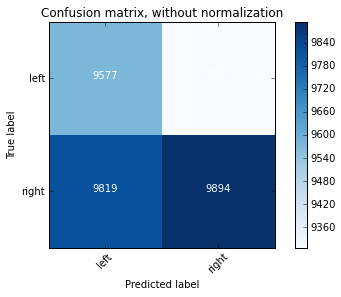

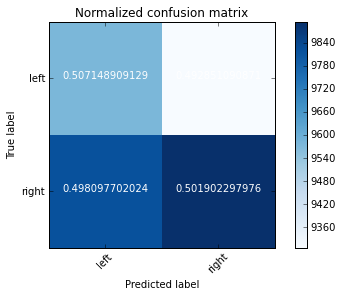

In [29]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets

from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
y_test = test.funnier
y_pred = funnier_test
class_names = ['left', 'right']
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


In [30]:
from sklearn.metrics import roc_auc_score
bin_ytest = [0 if x == 'left' else 1 for x in y_test]
bin_ypred = [0 if x == 'left' else 1 for x in y_pred]
roc_auc_score(bin_ytest, bin_ypred)

0.50452560355268827

In [31]:
from sklearn.metrics import f1_score
f1_score(bin_ytest, bin_ypred)


0.50850593616693218

In [22]:
regr.residues_

/usr/local/lib/python3.5/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


55.35168563838448

In [ ]:
# cross validation in the training set
#array_train = scipy_train.toarray()
#X = array_train.transpose()
X = scipy_train.transpose()
Y = label
num_folds = 100
num_instances = len(array_train)

In [ ]:
seed = 85
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
model = linear_model.LinearRegression()
scoring = 'mean_squared_error'

In [ ]:
results = cross_validation.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)

In [23]:
y_pred

array([  4.69489476e-04,   2.01457183e-04,   1.58268063e-02, ...,
        -1.71507470e-05,   1.37444097e-04,   5.45909678e-04])

In [30]:
len(y_pred)

3302579

In [37]:
scipy_test.shape[1]

3302579

In [38]:
data_test = pd.read_csv("../data/processed/test_dataset_with_lang_feature.csv", usecols=["videoId", "language"])
data_test_en = data_test[data_test.language == 'en']

In [49]:
abs(y_true[0:100] - y_pred[0:100])

array([  7.35829917e-03,   7.62633147e-03,   7.99901764e-03,
         7.71453452e-03,   7.67153479e-03,   7.27581953e-03,
         7.69271854e-03,   1.69077527e-02,   7.88125476e-03,
         7.71390734e-03,   5.62336135e-03,   6.88765657e-03,
         7.35528951e-03,   2.98176065e-03,   6.52931431e-03,
         8.08132795e-03,   3.18392141e-03,   8.25838991e-03,
         6.32018542e-03,   6.92705605e-03,   5.52418351e-03,
         9.87661070e-03,   8.77946834e-03,   7.25144446e-03,
         8.16230046e-03,   6.76981478e-03,   5.54015845e-03,
         7.74499825e-03,   9.76538354e-03,   7.88825711e-03,
         7.69524550e-03,   4.60531413e-02,   1.40600123e-02,
         6.47121088e-03,   7.48186833e-03,   1.31041487e-08,
         2.12433567e-01,   2.36854121e-01,   2.12393277e-01,
         2.40847834e-01,   2.25669176e-01,   2.12392864e-01,
         2.37185825e-01,   2.36029740e-01,   2.36562467e-01,
         2.38264018e-01,   2.37204077e-01,   2.31999283e-01,
         1.31041487e-08,

In [43]:
np.set_printoptions(threshold=np.nan)

In [52]:
y_true[0:100]

[0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0,
 -0.23679060665362034,
 -0.23679060665362034,
 -0.23679060665362034,
 -0.23679060665362034,
 -0.23679060665362034,
 -0.23679060665362034,
 -0.23679060665362

In [53]:
y_pred[0:100]

array([  4.69489476e-04,   2.01457183e-04,   1.58268063e-02,
         1.13254130e-04,   1.56253863e-04,   5.51969124e-04,
         1.35070114e-04,  -9.07996402e-03,  -5.34661094e-05,
         1.13881314e-04,   2.20442730e-03,   9.40132075e-04,
         4.72499141e-04,   1.08095493e-02,   1.29847434e-03,
        -2.53539300e-04,   4.64386724e-03,  -4.30601259e-04,
         1.50760323e-03,   9.00732597e-04,   2.30360514e-03,
        -2.04882205e-03,  -9.51679690e-04,   5.76344191e-04,
        -3.34511806e-04,   1.05797387e-03,   2.28763020e-03,
         8.27904018e-05,  -1.93759489e-03,  -6.04684590e-05,
         1.32543152e-04,   5.38809299e-02,  -6.23222366e-03,
         1.35657777e-03,   3.45920315e-04,   1.31041487e-08,
        -2.43570396e-02,   6.35144007e-05,  -2.43973298e-02,
         4.05722691e-03,  -1.11214311e-02,  -2.43977429e-02,
         3.95218181e-04,  -7.60866755e-04,  -2.28139684e-04,
         1.47341164e-03,   4.13470532e-04,  -4.79132327e-03,
         1.31041487e-08,